In [ ]:
import os
from os.path import join

import numpy as np
import pandas as pd

from google.colab import drive
import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

drive.mount('/content/drive')

datapath = join('data', 'wafer')

print(os.listdir("/content/drive/My Drive/input"))
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive
['LSWMD.pkl', 'test_wafer.jpg', 'wafer1.jpg', 'test_wafer1.jpg', 'test_wafer2.jpg', 'test_wafer3.jpg']


# **데이터 읽기**

In [ ]:
df=pd.read_pickle("/content/drive/My Drive/input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


데이터 세트는 웨이퍼 다이 크기, 로트 이름, 웨이퍼 인덱스 등의 추가 정보와 함께 811,457개의 웨이퍼 맵으로 구성됩니다.
훈련/테스트 세트는 이미 도메인 전문가에 의해 분할되었지만, 이 커널에서 우리는 이 정보를 무시하고 데이터 세트를 이후 섹션에 소개될 홀드아웃 방법에 의해 훈련 세트와 테스트 세트로 다시 분할했다.

# **대상 분포**

In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


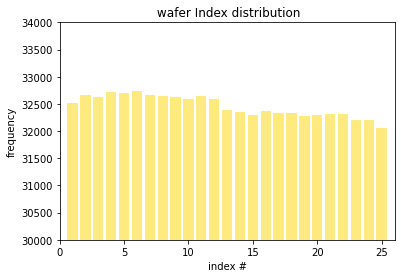

In [ ]:
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [ ]:
df = df.drop(['waferIndex'], axis = 1)

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
254410,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4612.0,lot15735,[],[],"(81, 73)"
270646,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1880.0,lot16690,[],[],"(42, 56)"
721126,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",811.0,lot43875,[[Test]],[[none]],"(34, 31)"
418781,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",899.0,lot25112,[],[],"(37, 31)"
770982,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1376.0,lot45893,[[Test]],[[none]],"(44, 41)"


In [ ]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [ ]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


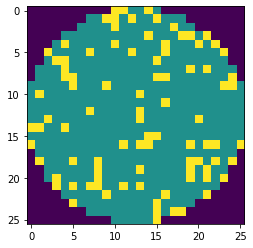

Faulty case : ['none'] 


In [ ]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [ ]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [ ]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [ ]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [ ]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [ ]:
# parameter
epoch=15
batch_size=1024

In [ ]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [ ]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [ ]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 8s - loss: 0.1586
Epoch 2/15
15/15 - 1s - loss: 0.0961
Epoch 3/15
15/15 - 1s - loss: 0.0813
Epoch 4/15
15/15 - 1s - loss: 0.0699
Epoch 5/15
15/15 - 1s - loss: 0.0616
Epoch 6/15
15/15 - 1s - loss: 0.0552
Epoch 7/15
15/15 - 1s - loss: 0.0498
Epoch 8/15
15/15 - 1s - loss: 0.0448
Epoch 9/15
15/15 - 1s - loss: 0.0394
Epoch 10/15
15/15 - 1s - loss: 0.0344
Epoch 11/15
15/15 - 1s - loss: 0.0302
Epoch 12/15
15/15 - 1s - loss: 0.0268
Epoch 13/15
15/15 - 1s - loss: 0.0241
Epoch 14/15
15/15 - 1s - loss: 0.0219
Epoch 15/15
15/15 - 1s - loss: 0.0201


In [ ]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [ ]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [ ]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [ ]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

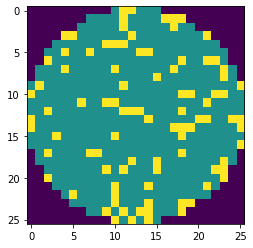

In [ ]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

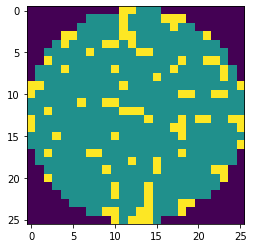

In [ ]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

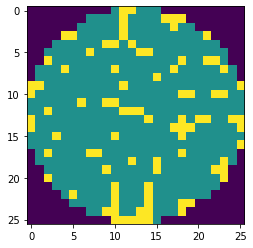

In [ ]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

In [ ]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [ ]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [ ]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [ ]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [ ]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


In [ ]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 3s - loss: 2.4043 - accuracy: 0.2562
Epoch 2/10
9/9 - 1s - loss: 1.1263 - accuracy: 0.6042
Epoch 3/10
9/9 - 1s - loss: 0.6937 - accuracy: 0.7540
Epoch 4/10
9/9 - 1s - loss: 0.4359 - accuracy: 0.8526
Epoch 5/10
9/9 - 1s - loss: 0.2453 - accuracy: 0.9244
Epoch 6/10
9/9 - 1s - loss: 0.1642 - accuracy: 0.9507
Epoch 7/10
9/9 - 1s - loss: 0.1033 - accuracy: 0.9703
Epoch 8/10
9/9 - 1s - loss: 0.0657 - accuracy: 0.9834
Epoch 9/10
9/9 - 1s - loss: 0.0487 - accuracy: 0.9872
Epoch 10/10
9/9 - 1s - loss: 0.0509 - accuracy: 0.9852
5/5 - 0s - loss: 0.0483 - accuracy: 0.9852
Epoch 1/10
9/9 - 2s - loss: 1.9251 - accuracy: 0.4145
Epoch 2/10
9/9 - 1s - loss: 0.8686 - accuracy: 0.6809
Epoch 3/10
9/9 - 1s - loss: 0.5700 - accuracy: 0.7987
Epoch 4/10
9/9 - 1s - loss: 0.3252 - accuracy: 0.9006
Epoch 5/10
9/9 - 1s - loss: 0.1589 - accuracy: 0.9525
Epoch 6/10
9/9 - 1s - loss: 0.0869 - accuracy: 0.9761
Epoch 7/10
9/9 - 2s - loss: 0.0449 - accuracy: 0.9893
Epoch 8/10
9/9 - 2s - loss: 0.0346 - a

In [ ]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size,
                    epochs=epoch                    
                    )

Epoch 1/15
13/13 - 4s - loss: 1.8170 - accuracy: 0.3405 - val_loss: 1.0427 - val_accuracy: 0.6065
Epoch 2/15
13/13 - 3s - loss: 0.7459 - accuracy: 0.7298 - val_loss: 0.5536 - val_accuracy: 0.7789
Epoch 3/15
13/13 - 3s - loss: 0.3654 - accuracy: 0.8807 - val_loss: 0.2366 - val_accuracy: 0.9239
Epoch 4/15
13/13 - 3s - loss: 0.1853 - accuracy: 0.9415 - val_loss: 0.1499 - val_accuracy: 0.9530
Epoch 5/15
13/13 - 3s - loss: 0.1089 - accuracy: 0.9688 - val_loss: 0.1303 - val_accuracy: 0.9633
Epoch 6/15
13/13 - 3s - loss: 0.0615 - accuracy: 0.9833 - val_loss: 0.0672 - val_accuracy: 0.9794
Epoch 7/15
13/13 - 3s - loss: 0.0321 - accuracy: 0.9926 - val_loss: 0.0349 - val_accuracy: 0.9903
Epoch 8/15
13/13 - 3s - loss: 0.0155 - accuracy: 0.9974 - val_loss: 0.0343 - val_accuracy: 0.9902
Epoch 9/15
13/13 - 3s - loss: 0.0115 - accuracy: 0.9980 - val_loss: 0.0331 - val_accuracy: 0.9892
Epoch 10/15
13/13 - 3s - loss: 0.0083 - accuracy: 0.9986 - val_loss: 0.0339 - val_accuracy: 0.9897
Epoch 11/15
13/13 -

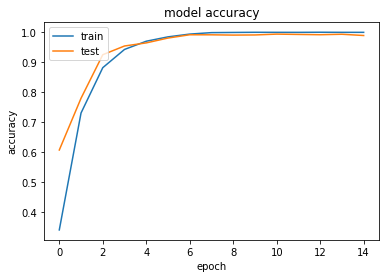

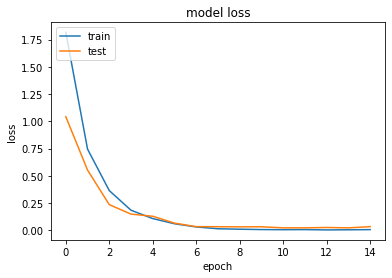

In [ ]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 7. 모델 저장하기
from tensorflow.python.keras.models import load_model
model.save('/content/drive/My Drive/wafer_model.h5')

AttributeError: ignored